In [244]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from torch.utils.data import Dataset,DataLoader
import torchvision.transforms as transforms
from  torchvision.datasets import ImageFolder
from torch.autograd import Variable
import cv2
import numpy as np
import os, random,sys
from torchvision.utils import save_image
import torch.nn.functional as F


# Build an Autoencoder for a human face dataset

We will use a dataset containig images of people and train an autoencoder on it. 

## Step 1

Download and unzip the ``lfw.zip`` file . Adjust the ``path`` variable so that it contains the address of the unzipped folder. We will create a dataloader from this folder.


In [245]:
path = 'dataset/lfw'

In [246]:
transform    = transforms.Compose([transforms.ToTensor()]) 
dataloader = DataLoader(ImageFolder(path, transform,),batch_size=32, shuffle=True)

This project is compute intensive. If you have a cuda or mps device on your laptop make sure you use that in the training.

In [247]:
# Uses MPS on Mac devices to help with computation speed
if torch.backends.mps.is_available():
    device = torch.device("mps")
else:
    print ("MPS device not found.")

In [248]:
# Creates a folder for generated images if it doesn't already exist
if not os.path.exists('./generated'):
    os.mkdir('./generated')

In [249]:
def to_img(x):
    # 4D tensor with shape [batch_size, channels, height, width]
    batch_size = x.size(0)
    channels = x.size(1)
    height = x.size(2)
    width = x.size(3)

    # Reshape the tensor to [batch_size, channels, height, width]
    x = x.view(batch_size, channels, height, width)
    return x

## Step 2
Each datapoint is an image. Get a sample of the data and print its dimensions and explain what each dimension means.

torch.Size([250, 250, 3])


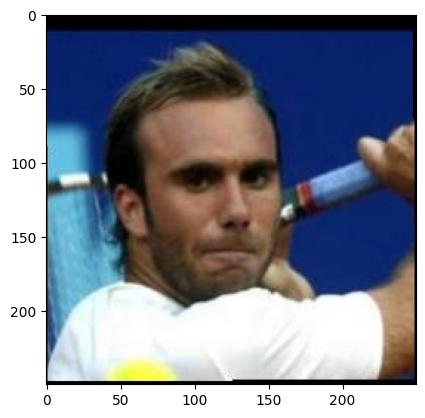

In [250]:
# Gets one example image from the dataset
for x,y in dataloader:
    x = x[0].permute(1, 2, 0)
    print(x.shape)
    plt.imshow(x)
    break

[250, 250, 3]

250: height

250: width

3: represents the RGB dimension / color channel.

# Step 3

Create a new pytorch model calss for your autoencoder. You can use Conv2d, MaxPool2d, BatchNorm2d, ConvTranspose2d and Linear Layers as as well as activation functions. Optionally, you can use UpSample, AveragePool2d and Interpolate2d as well.

**Create seperate functions for the encoder and decoder.**

In [251]:
class AE(nn.Module):
    def __init__(self):
        super(AE,self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 16, 3, stride=2, padding=1), # Input (# of color channels), Output, Kernal Size (How big the Conv is)
            nn.BatchNorm2d(16), # Normalizes our data using the output of the Conv2d
            nn.ReLU(True), # Activation function
            nn.MaxPool2d(2, stride=2), # Pools our data and grabs the max value from it
            nn.Conv2d(16, 32, 3, stride=2, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(True),
            nn.MaxPool2d(2, stride=2),
            nn.Conv2d(32, 64, 3, stride=2, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(True),
            nn.MaxPool2d(2, stride=1)
        )
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(64, 32, 3, stride=2),
            nn.BatchNorm2d(32),
            nn.ReLU(True),
            nn.ConvTranspose2d(32, 16, 3, stride=2, padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU(True),
            nn.ConvTranspose2d(16, 3, 3, stride=2, padding=1),
            nn.Upsample((250, 250), mode='bilinear'), # Scales our data to size given in parameter
            nn.Tanh()
        )
    
    # Wrapper function for encoder
    def encode(self,x):
        return self.encoder(x)
        
    # Wrapper function for decoder
    def decode(self,x):
        return self.decoder(x)
    
    def forward(self,x):
        h   = self.encoder(x)
        out = self.decoder(h)
        return out
       

## Step 4
Create an instance of the class, pass an image to the model, print the shape of the output of the **encoder** and the **decoder**. Check the dimensions and make sure your forward path is working properly.

In [252]:
# Instance of our AutoEncoder
model = AE().to(device)

In [253]:
# Checking if our model is working properly by checking its shape
for data in dataloader:
    img, y = data
    img = img.to(device)
    encoded_img = model.encode(img)
    decoded_img = model.decode(encoded_img)
    print("Original Image:", img.shape) # [batch_size, RGB, Dimensions]
    print("Encoded Image:", encoded_img.shape)
    print("Decoded Image:", decoded_img.shape)
    break

Original Image: torch.Size([32, 3, 250, 250])
Encoded Image: torch.Size([32, 64, 7, 7])
Decoded Image: torch.Size([32, 3, 250, 250])


##  Step 5
Print total number of parameters in the model, explain what loss function you should use, create an optimizer for training

In [254]:
size = 0
for parameter in model.parameters():
    size += parameter.numel()
print("Parameter size:", size)

Parameter size: 47427


In [255]:
optim = torch.optim.Adam(model.parameters(), lr=0.001)

We use MSE as our loss function because we want to see the difference between the decoded image to the original, and we're trying to minimize that loss.

In [256]:
loss_function = nn.MSELoss()

##  Step 6
Write a training loop and start trainng the model for several epochs. Report the loss value at the end of each epoch and monitor it. If your loss is not decreasing what do you have to do to troubleshoot it ?

In [257]:
# Training loop
num_epochs = 100
for epoch in range(num_epochs):
    total_loss = 0
    for data in dataloader:
        img, y = data
        img = img.to(device)

        # ===================forward=====================
        output = model(img)
        loss = loss_function(img, output)
        
        # ===================backward====================
        
        optim.zero_grad()
        loss.backward()
        optim.step()
        total_loss += loss.data
        
    # ===================log========================
    print('epoch [{}/{}], loss:{:.4f}'
          .format(epoch+1, num_epochs, total_loss))
    if epoch % 10 == 0:
        pic = to_img(output.cpu().data)
        save_image(pic, './generated/image_{}.png'.format(epoch))

epoch [1/100], loss:13.9708
epoch [2/100], loss:7.6737
epoch [3/100], loss:7.0556
epoch [4/100], loss:6.6962
epoch [5/100], loss:6.4816
epoch [6/100], loss:6.3187
epoch [7/100], loss:6.1629
epoch [8/100], loss:6.0626
epoch [9/100], loss:5.9643
epoch [10/100], loss:5.8692
epoch [11/100], loss:5.7934
epoch [12/100], loss:5.7242
epoch [13/100], loss:5.6588
epoch [14/100], loss:5.5816
epoch [15/100], loss:5.5553
epoch [16/100], loss:5.5035
epoch [17/100], loss:5.4662
epoch [18/100], loss:5.4484
epoch [19/100], loss:5.3794
epoch [20/100], loss:5.3280
epoch [21/100], loss:5.3461
epoch [22/100], loss:5.2953
epoch [23/100], loss:5.2603
epoch [24/100], loss:5.2462
epoch [25/100], loss:5.2228
epoch [26/100], loss:5.1782
epoch [27/100], loss:5.1996
epoch [28/100], loss:5.1352
epoch [29/100], loss:5.1365
epoch [30/100], loss:5.1212
epoch [31/100], loss:5.0917
epoch [32/100], loss:5.0763
epoch [33/100], loss:5.0780
epoch [34/100], loss:5.0425
epoch [35/100], loss:5.0493
epoch [36/100], loss:5.0298


##  Step 7

Take a random image from the dataset and plot it against the reconstructed (encoded + decoded) image.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


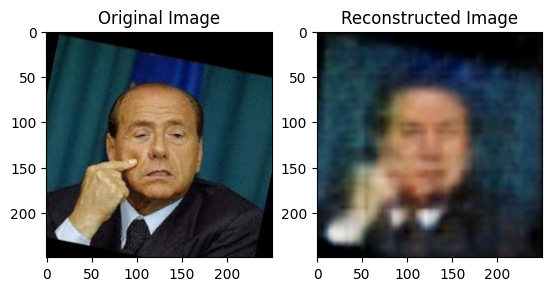

In [258]:
def plot_image_pair(x, y):
    # Convert tensors to NumPy arrays
    x_np = x.detach().cpu().numpy()
    y_np = y.detach().cpu().numpy()

    # Transpose the dimensions to match the expected format
    x_np = np.transpose(x_np, (1, 2, 0))
    y_np = np.transpose(y_np, (1, 2, 0))

    plt.subplot(121)
    plt.imshow(x_np)
    plt.title('Original Image')

    plt.subplot(122)
    plt.imshow(y_np)
    plt.title('Reconstructed Image')

    plt.show()

for data in dataloader:
    img, y = data
    img = img.to(device)

    # Forward pass through the model
    output = model(img)

    # Visualize the original and reconstructed images
    plot_image_pair(img[0, :, :, :], output[0, :, :, :])
    break

##  Step 8

In step 7, add a small normaly distrubuted noise to the latent (hidden) representation of the input image and then decode it again. How is adding noise affecting the decoded image ?

In [259]:
def plot_image_triplet(x, y, z):
    # Convert tensors to NumPy arrays
    x_np = x.detach().cpu().numpy()
    y_np = y.detach().cpu().numpy()
    z_np = z.detach().cpu().numpy()

    # Transpose the dimensions to match the expected format
    x_np = np.transpose(x_np, (1, 2, 0))
    y_np = np.transpose(y_np, (1, 2, 0))
    z_np = np.transpose(z_np, (1, 2, 0))
    
    plt.subplot(131)
    plt.imshow(x_np)
    plt.title('Original Image')

    plt.subplot(132)
    plt.imshow(y_np)
    plt.title('Noisy Image')
    
    plt.subplot(133)
    plt.imshow(z_np)
    plt.title('Decoded Image')

    plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


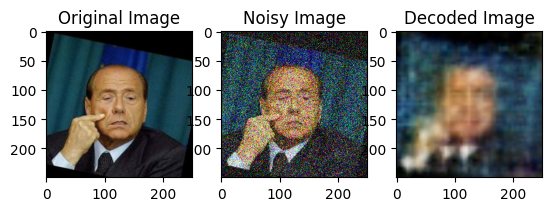

In [260]:
noise = 0.3

# Add noise to our original image
noise = torch.randn_like(img) * noise
noise_img = img + noise

# Forward pass our noise image
encoded_img = model.encode(noise_img)

# Decode the noise image
decoded_img = model.decode(encoded_img)

# Visualize the original and reconstructed images
plot_image_triplet(img[0, :, :, :], noise_img[0, :, :, :], decoded_img[0, :, :, :])

Adding noise made my decoded image more blurry than it already was. In theory, if my decoded image was cleaner, I can see my decoder looking better because it should be able to see a pattern of what belongs there and what is actually noise, then get rid of the noise and produce a crispier image.